

## Project 1B: BC (microg/m3) Multilevel Discrete Wavelet Transform of 1D Time Series



### Project Objective 
Identify vehicles releasing pollutants, Black Carbon, oxides of nitrogen and GHG (CO2) 
#### Use Disrete Wavelet transform and 1D time series to denoise the signal
- Make multilevel decomposition 
- Visualize the Approximation and Details coeffcients
- Reconstruct orignal time series signal
- Reconstruct the Approximation and Details
- Visualize the Approximation and Details
- reduce data noise at different levels and visualizae the results

### Import required packages

In [1]:
import os
import glob
import csv
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy import signal
import pywt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import seaborn as sns

# Handle date time conversions between pandas and matplotlib
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
os.getcwd()

'C:\\Users\\bina_\\Dropbox\\Robina Shaheen_PEMS2022\\PEMS_NOx_BC_CO2_ALPR\\ii.dwt'

### Read the data

In [2]:
# base_path=os.path.join ('ii.dwt','data')
# base_path
df = pd.read_csv('./data/2022-09-02/ma300.csv')
print(df.head(3))
print(df.tail(3))


                         Time Serial Number  Datum ID  Session ID  \
0  2022-09-02 00:00:01.856921    MA300-0075  180654.0        19.0   
1  2022-09-02 00:00:02.836060    MA300-0075  180655.0        19.0   
2  2022-09-02 00:00:03.854123    MA300-0075  180656.0        19.0   

   Data format version  Firmware Version               Date Time  \
0                  1.0               1.1  2022-09-02T07:00:00.00   
1                  1.0               1.1  2022-09-02T07:00:01.00   
2                  1.0               1.1  2022-09-02T07:00:02.00   

   Timezone offset    GPS Lat    GPS Long  ...  Green BC1  Green BC2  \
0           -420.0  33.606471 -114.535798  ...      654.0        NaN   
1           -420.0  33.606454 -114.535801  ...     1576.0        NaN   
2           -420.0  33.606450 -114.535808  ...     1038.0        NaN   

   Green BCc  Red BC1  Red BC2  Red BCc  IR BC1  IR BC2  IR BCc  CKSUM  
0        NaN    703.0      NaN      NaN  1213.0     NaN     NaN   50AB  
1        NaN   

In [3]:
print(df.columns)
print(df.shape)
df = df.ffill().bfill()
#df.info()

Index(['Time', 'Serial Number', 'Datum ID', 'Session ID',
       'Data format version', 'Firmware Version', 'Date Time',
       'Timezone offset', 'GPS Lat', 'GPS Long', 'GPS Speed', 'Timebase',
       'Status', 'Battery', 'Accel X', 'Accel Y', 'Accel Z', 'Tape Position',
       'Flow Set', 'Flow Total', 'Flow 1', 'Flow 2', 'Air Temp', 'Air RH',
       'Air DP', 'Int Pr', 'Int Temp', 'Optical config', 'UV Sen1', 'UV Sen2',
       'UV Ref', 'UV ATN1', 'UV ATN2', 'UV K', 'Blue Sen1', 'Blue Sen2',
       'Blue Ref', 'Blue ATN1', 'Blue ATN2', 'Blue K', 'Green Sen1',
       'Green Sen2', 'Green Ref', 'Green ATN1', 'Green ATN2', 'Green K',
       'Red Sen1', 'Red Sen2', 'Red Ref', 'Red ATN1', 'Red ATN2', 'Red K',
       'IR Sen1', 'IR Sen2', 'IR Ref', 'IR ATN1', 'IR ATN2', 'IR K', 'UV BC1',
       'UV BC2', 'UV BCc', 'Blue BC1', 'Blue BC2', 'Blue BCc', 'Green BC1',
       'Green BC2', 'Green BCc', 'Red BC1', 'Red BC2', 'Red BCc', 'IR BC1',
       'IR BC2', 'IR BCc', 'CKSUM'],
      dtype='ob

In [4]:
print('Empty cells/ zero values:', df.isnull().sum())

Empty cells/ zero values: Time                       0
Serial Number              0
Datum ID                   0
Session ID                 0
Data format version        0
                       ...  
Red BCc                71476
IR BC1                     0
IR BC2                 71476
IR BCc                 71476
CKSUM                      0
Length: 74, dtype: int64


### Transform and select  BC Data 

In [5]:
df['time2'] = df['Time'].astype(str).str.split().str[1]
# df['time2'] = df['Time'].dt.strftime('%H:%M:%S')
df.tail(3)

,Time,Serial Number,Datum ID,Session ID,Data format version,Firmware Version,Date Time,Timezone offset,GPS Lat,GPS Long,...,Green BC2,Green BCc,Red BC1,Red BC2,Red BCc,IR BC1,IR BC2,IR BCc,CKSUM,time2
71473,2022-09-02 23:59:58.555425,MA300-0075,267035.0,19.0,1.0,1.1,2022-09-03T06:59:56.00,-420.0,33.606223,-114.535750,...,NaN,NaN,854.0,NaN,NaN,294.0,NaN,NaN,509C,23:59:58.555425
71474,2022-09-02 23:59:59.555325,MA300-0075,267036.0,19.0,1.0,1.1,2022-09-03T06:59:57.00,-420.0,33.606218,-114.535751,...,NaN,NaN,25.0,NaN,NaN,796.0,NaN,NaN,5054,23:59:59.555325
71475,2022-09-03 00:00:00.555224,MA300-0075,267037.0,19.0,1.0,1.1,2022-09-03T06:59:58.00,-420.0,33.606216,-114.535746,...,NaN,NaN,880.0,NaN,NaN,195.0,NaN,NaN,5044,00:00:00.555224


In [6]:
df["IR BC1_ug"] = df["IR BC1"]/ 1000+1
df.head(3)

,Time,Serial Number,Datum ID,Session ID,Data format version,Firmware Version,Date Time,Timezone offset,GPS Lat,GPS Long,...,Green BCc,Red BC1,Red BC2,Red BCc,IR BC1,IR BC2,IR BCc,CKSUM,time2,IR BC1_ug
0,2022-09-02 00:00:01.856921,MA300-0075,180654.0,19.0,1.0,1.1,2022-09-02T07:00:00.00,-420.0,33.606471,-114.535798,...,NaN,703.0,NaN,NaN,1213.0,NaN,NaN,50AB,00:00:01.856921,2.213
1,2022-09-02 00:00:02.836060,MA300-0075,180655.0,19.0,1.0,1.1,2022-09-02T07:00:01.00,-420.0,33.606454,-114.535801,...,NaN,756.0,NaN,NaN,889.0,NaN,NaN,5098,00:00:02.836060,1.889
2,2022-09-02 00:00:03.854123,MA300-0075,180656.0,19.0,1.0,1.1,2022-09-02T07:00:02.00,-420.0,33.606450,-114.535808,...,NaN,2207.0,NaN,NaN,522.0,NaN,NaN,5110,00:00:03.854123,1.522


In [7]:
df2 = pd.DataFrame(df,
                  columns=['time2', 'IR BC1_ug'])
df2.head(3)

,time2,IR BC1_ug
0,00:00:01.856921,2.213
1,00:00:02.836060,1.889
2,00:00:03.854123,1.522


In [80]:
df_BC = df2[['IR BC1_ug']].agg(['min','max', 'mean'])
print(len(df2))
print (df_BC)

71476
       IR BC1_ug
min   -10.896000
max   329.810000
mean    2.612991


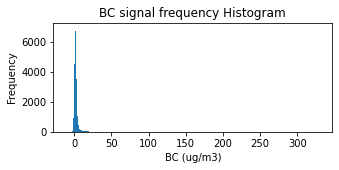

In [8]:
# df2 = pd.DataFrame(df,
#                   columns=['time2', 'IR BC1_ug'])
# from brokenaxes import brokenaxes
fig = plt.figure(figsize=(5, 2))
# bax = brokenaxes(xlims=((-1, 1), (1, 40), (50,300)), 
#                  ylims=((0, 10), (50, 100)), hspace=.05)
# x = np.linspace(0, 1, 100)
# bax.plot(x, np.sin(10 * x), label='sin')
# x= df2['IR_BC1_ug']
# bax.plot(x,  label='cos')
# bax.legend()
# bax.set_xlabel('BC')
# bax.set_ylabel('Frequency')
# # Import seaborn
# import seaborn as sns
# sns.displot(data=df2, x="total_bill", col="time", kde=True)
# Plot Histogram on x
# plt.rcParams["figure.figsize"] = (6, 4)
# df2 = pd.DataFrame(df,
#                   columns=['Time', 'IR BC1'])
# df2["IR_BC1_ug"] = df["IR BC1"] / 1000
# df2.head()
x= df2['IR BC1_ug']
plt.hist(x, bins = 1000)
plt.gca().set(title='BC signal frequency Histogram', 
              xlabel= 'BC (ug/m3)', ylabel='Frequency'); 

In [9]:
# import scipy
# from scipy import stats

In [10]:
# observation_x = df2['IR BC1_ug']
# histogram, bins = scipy.histogram(['observation_x'],
# bins = range(4))
# print ("Number of values in each bin : ", histogram)
# print ("Size of the bins          : ", bins)

# CDF_norm = stats.norm.CDF(observatin_x,loc=0,scale=1)

In [11]:
# plt.plot(observatin_x,CDF_norm)
# plt.xlabel('x-values')
# plt.ylabel('CDF_norm_values')
# plt.title("Comulative distribution function")
# plt.show()

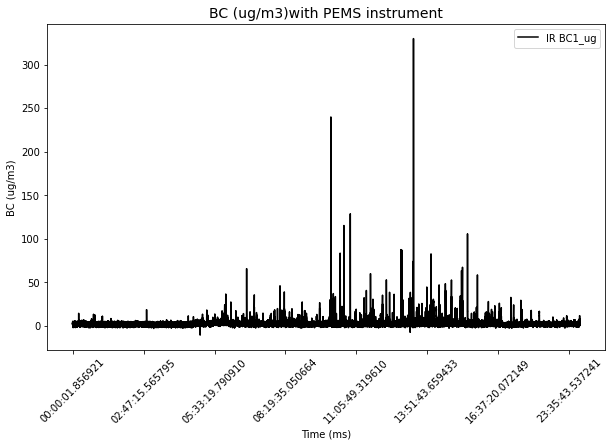

In [12]:
# set plot size for the plot
# plt.rcParams["date.autoformatter.minute"] = "%H:%M:%S"
# fig, (ax) = plt.subplots(constrained_layout=True)
# yticks = np.arange(-50, 300, 50)
# yrange = (yticks[0], yticks[-1])
# xticks = np.arange(0, 8000, 1000)
plt.rcParams["figure.figsize"] = (10, 6)
offset = -.03
# df2 = pd.DataFrame(df,
#                   columns=['Time', 'IR BC1_ug'])

df2.plot(x='time2', y='IR BC1_ug',color="black")

# plt.setp(ax.get_xticklabels(), rotation=45)
# Define the date format
# format your data to desired format. 

#import matplotlib.dates as mdates
# ax = plt.gca()
# ax.axis.set_major_formatter(mdates.DateFormatter('%H-%M-%S'))
# date_form = DateFormatter("%H-%M:%S")
# ax.axis.set_major_formatter(date_form)
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
# fig.autofmt_xdate()
plt.ylabel('BC (ug/m3)')
plt.xlabel('Time (ms)')
plt.title("BC (ug/m3)with PEMS instrument", fontsize=14)
plt.show()

### Slice  data for wavelet transformations

In [13]:
# t = df2['time2'].astype('datetime64[s]')

t = df2['time2']
s = df2['IR BC1_ug']
print(type(t))
print(len(t))
print(t.head(3))
print(t.tail(3))


<class 'pandas.core.series.Series'>
71476
0    00:00:01.856921
1    00:00:02.836060
2    00:00:03.854123
Name: time2, dtype: object
71473    23:59:58.555425
71474    23:59:59.555325
71475    00:00:00.555224
Name: time2, dtype: object


### (4) Plot the signal

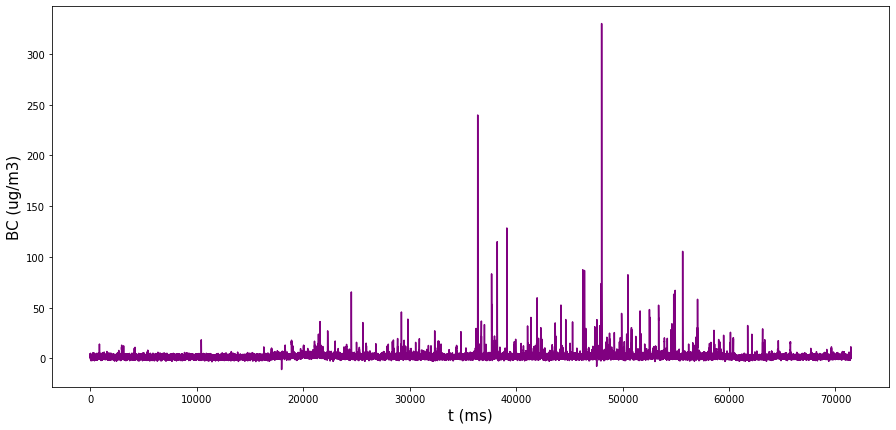

In [14]:
fig,ax = plt.subplots(figsize=(15,7))

plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)

# ax.plot(t,s)
# Add x-axis and y-axis
ax.plot(df2.index.values,
       df2['IR BC1_ug'],
       color='purple')
ax.set_xlabel('t (ms)',fontsize=15)
ax.set_ylabel('BC (ug/m3)',fontsize=15)

plt.savefig('./results/BC_ug_PEMS.png',dpi=300)
plt.show()

## 4. Perform Multi-level Wavelet Decomposition

### (1) Maximum decomposition level

In [15]:
w = pywt.Wavelet('db6')
l = len(s)
f_l = w.dec_len

max_l = pywt.dwt_max_level(data_len=l, filter_len=f_l)

print(max_l)

12


### (2) Wavelet decomposition

In [16]:
coeffs = pywt.wavedec(s,'db6','sym',level=6)

(cA6,cD6,cD5,cD4,cD3,cD2,cD1) = coeffs

### (3) Print the approximation and detail coefficients

In [17]:
print('cA6 = ',cA6)
print('cD6 = ',cD6)

cA6 =  [18.41214711 18.32779113 18.34299683 ... 21.20987432 31.43566052
  8.79133418]
cD6 =  [-3.65599426e-02 -5.16085000e-04 -2.27489883e-01 ...  2.90468032e+00
 -3.90353862e+00 -8.51287344e-01]


### (3) length of the coefficients 

In [18]:
print(len(s))
print(len(cA6))
print(len(cD6))

71476
1127
1127


## 5. Visualization of  Approximation and Details Coefficients

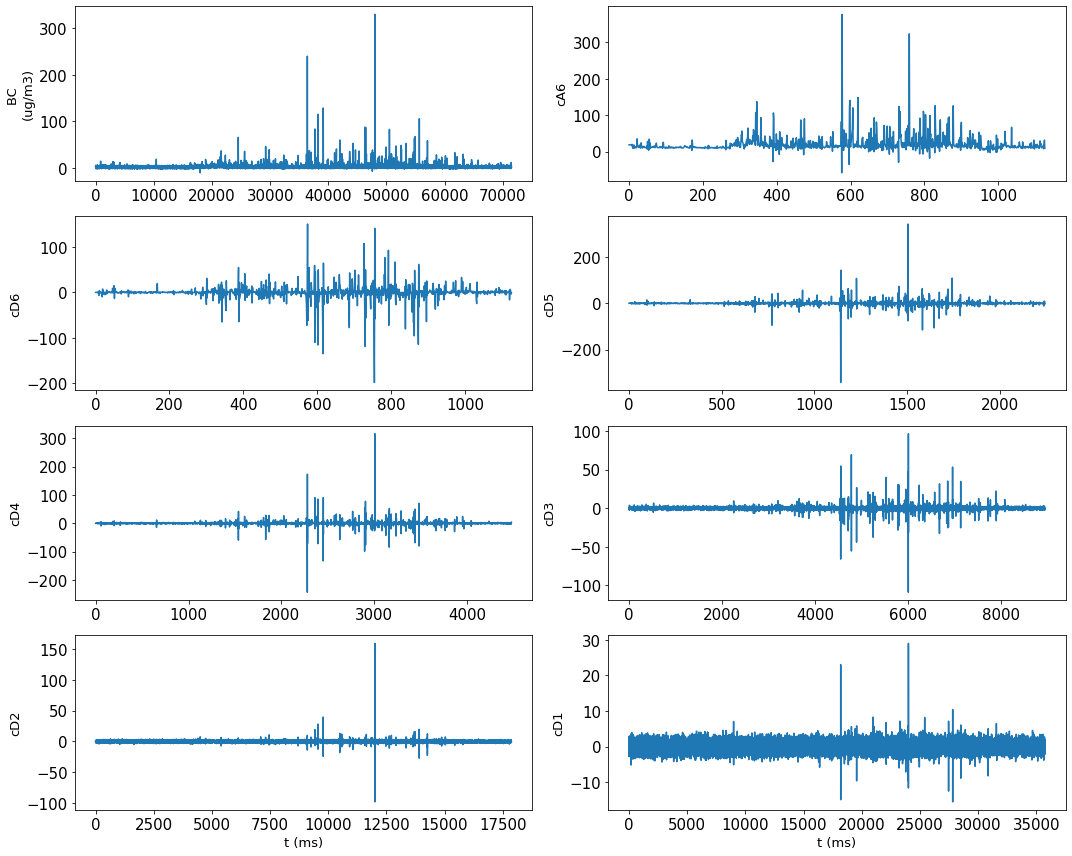

In [19]:
fig,axs = plt.subplots(4,2,figsize=(15,12))

plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)

axs[0,0].plot(s)
axs[0,0].set_ylabel('BC \n(ug/m3)',fontsize=13)

axs[0,1].plot(cA6)
axs[0,1].set_ylabel('cA6',fontsize=13)

axs[1,0].plot(cD6)
axs[1,0].set_ylabel('cD6',fontsize=13)

axs[1,1].plot(cD5)
axs[1,1].set_ylabel('cD5',fontsize=13)

axs[2,0].plot(cD4)
axs[2,0].set_ylabel('cD4',fontsize=13)

axs[2,1].plot(cD3)
axs[2,1].set_ylabel('cD3',fontsize=13)

axs[3,0].plot(cD2)
axs[3,0].set_ylabel('cD2',fontsize=13)
axs[3,0].set_xlabel('t (ms)',fontsize=13)

axs[3,1].plot(cD1)
axs[3,1].set_ylabel('cD1',fontsize=13)
axs[3,1].set_xlabel('t (ms)',fontsize=13)

plt.tight_layout()
plt.savefig('./results/BC_ug_s_coeffs.png',dpi=300, bbox_inches='tight')

plt.show()

## 6. Reconstruct the Signal

In [20]:
s_r = pywt.waverec(coeffs,'db6','sym')
s_r

array([2.213, 1.889, 1.522, ..., 1.294, 1.796, 1.195])

In [21]:
df3= pd.DataFrame(s_r,columns=['recon_s'] )
# df3
# df3.rename(columns={'0':'s_r'}, inplace=True)
df3
# combined_sig = pd.concat([df3, df2])
# combined_sig

,recon_s
0,2.213
1,1.889
2,1.522
3,2.548
4,2.735
...,...
71471,4.012
71472,3.634
71473,1.294
71474,1.796


In [22]:
print(len(s))
print(len(s_r))

71476
71476


### (2) reconstructed signal

In [23]:
# # errors

# err = sum(s-s_r)/len(s)
# max_err = max(abs(s-s_r))

# print(err)
# print(max_err)

In [24]:
# s_r = s_r[:-1]

### (3) Comparing reconstructed signal with the original one

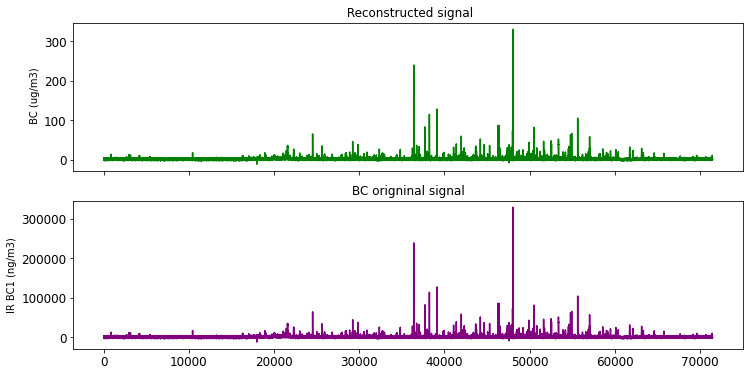

In [25]:
# plot
fig,(ax1,ax2) = plt.subplots(2,1, sharex= True, figsize=(12,6))
# Add x-axis and y-axis
ax1.plot(df3.index.values,
       df3['recon_s'],
       color='green')
ax2.plot(df.index.values,
       df['IR BC1'],
       color='purple')
ax2.set(
    ylabel="IR BC1 (ng/m3)",
    title="BC origninal signal")
ax1.set(#xlabel = "Time (ms)",
    ylabel=" BC (ug/m3)",
    title=" Reconstructed signal")
# ax.plot(t,s)
# ax.plot(t,s_r)

plt.show()

## 7. Reconstruct Approximations and Details 

### (1) Create zero arrays

In [26]:
cA06 = np.zeros(len(cA6))
cD06 = np.zeros(len(cD6))
cD05 = np.zeros(len(cD5))
cD04 = np.zeros(len(cD4))
cD03 = np.zeros(len(cD3))
cD02 = np.zeros(len(cD2))
cD01 = np.zeros(len(cD1))

In [27]:
print(cA06)

[0. 0. 0. ... 0. 0. 0.]


### (2) Reconstruct Approximations and Details

In [28]:
A6 = pywt.waverec((cA6,cD06,cD05,cD04,cD03,cD02,cD01),'db6','sym')
D6 = pywt.waverec((cA06,cD6,cD05,cD04,cD03,cD02,cD01),'db6','sym')
D5 = pywt.waverec((cA06,cD06,cD5,cD04,cD03,cD02,cD01),'db6','sym')
D4 = pywt.waverec((cA06,cD06,cD05,cD4,cD03,cD02,cD01),'db6','sym')
D3 = pywt.waverec((cA06,cD06,cD05,cD04,cD3,cD02,cD01),'db6','sym')
D2 = pywt.waverec((cA06,cD06,cD05,cD04,cD03,cD2,cD01),'db6','sym')
D1 = pywt.waverec((cA06,cD06,cD05,cD04,cD03,cD02,cD1),'db6','sym')

In [29]:
# check the length

print(len(s))
print(len(A6))

71476
71476


In [30]:
# A6 = A6[:-1]
# D6 = D6[:-1]
# D5 = D5[:-1]
# D4 = D4[:-1]
# D3 = D3[:-1]
# D2 = D2[:-1]
# D1 = D1[:-1]

### (3) Approximations at other levels

In [31]:
A5 = A6 + D6 
A4 = A6 + D6 + D5
A3 = A6 + D6 + D5 + D4
A2 = A6 + D6 + D5 + D4 + D3
A1 = A6 + D6 + D5 + D4 + D3 + D2

### (4) Reconstruct signal from approximation and details

In [32]:
s_r = A6 + D6 + D5 + D4 + D3 + D2 + D1

In [33]:
app6= pd.DataFrame(A6,columns=['Approx_6'] )
app6
df6_s = app6[['Approx_6']].agg(['min','max', 'mean'])
print (df6_s)

       Approx_6
min  -12.543724
max   54.082820
mean   2.612569


In [34]:
# Reconstructed signal from approximation
app3= pd.DataFrame(A3,columns=['Approx_3'] )
app3
arr3 = app3.to_numpy()
arr3
# arr3.dtype
# app2= pd.DataFrame(A2,columns=['Approx_2'] )
# app2
df3_s = app3[['Approx_3']].agg(['min','max', 'mean'])
print (df3_s)

        Approx_3
min   -20.983127
max   241.265784
mean    2.612998


In [35]:
# app3= pd.DataFrame(A3,columns=['Approx_3'] )

# combined_df= [app6, t]
recon_s6_t= pd.concat([app6, t], axis = 1)
# recon_s_t['time'] = recon_s_t['time2'].astype('datetime64[s]')

# app3.to_csv('./data/IR_BC1_ug_denoised_signal.csv',index=False)
recon_s6_t.to_csv('./Results2/IR_BC1_ug_denoised_recon_s6_t.csv',index=True)
print(recon_s6_t.head())
# df_s = recon_s_t[['Approx_3']].agg(['min','max'])
# print (df_s)
recon_s6_t.tail()

   Approx_6            time2
0  2.315691  00:00:01.856921
1  2.305682  00:00:02.836060
2  2.295022  00:00:03.854123
3  2.283770  00:00:04.823282
4  2.271940  00:00:05.836354


,Approx_6,time2
71471,3.638366,23:59:56.562332
71472,3.624850,23:59:57.572229
71473,3.609733,23:59:58.555425
71474,3.593153,23:59:59.555325
71475,3.575240,00:00:00.555224


In [60]:
s3= pd.concat([app3, t], axis = 1)
# take slice of data
# s3= s3[:4000]
print(len(s3))
print(s3.head(3))
s3.tail(3)

71476
   Approx_3            time2
0  2.172161  00:00:01.856921
1  2.277492  00:00:02.836060
2  2.403230  00:00:03.854123


,Approx_3,time2
71473,2.141133,23:59:58.555425
71474,1.947308,23:59:59.555325
71475,1.769353,00:00:00.555224


In [61]:
df_s3 = s3[['Approx_3']].agg(['min','max', 'mean'])
print (df_s3)

        Approx_3
min   -20.983127
max   241.265784
mean    2.612998


In [62]:
#convert DF to array
#peak_time2=s3["time2"].astype('datetime64[s]') ## to remove ms
peak_time3=s3["time2"].values
print(peak_time3)
# peak_date=recon_s_t["time"].values
# print(peak_date)
peak_ss3=s3["Approx_3"].values
print(peak_ss3)
s3_xarr= peak_time3
s3_yarr= peak_ss3

['00:00:01.856921' '00:00:02.836060' '00:00:03.854123' ...
 '23:59:58.555425' '23:59:59.555325' '00:00:00.555224']
[2.17216081 2.27749165 2.40322988 ... 2.14113299 1.94730786 1.76935346]


In [39]:
# df_s = recon_s_t[['Approx_3']].agg(['min','max', 'mean'])
# print (df_s)

In [40]:
#convert DF to array
peak_date6=recon_s6_t["time2"].values
print(peak_date6)
# peak_date=recon_s_t["time"].values
# print(peak_date)
peak_sig6=recon_s6_t["Approx_6"].values
peak_sig6

['00:00:01.856921' '00:00:02.836060' '00:00:03.854123' ...
 '23:59:58.555425' '23:59:59.555325' '00:00:00.555224']


array([2.31569126, 2.30568238, 2.29502186, ..., 3.60973318, 3.59315255,
       3.57524002])

In [41]:
# # errors

# err = sum(s-s_r)/len(s)
# max_err = max(abs(s-s_r))

# print(err)
# print(max_err)

## 8. Visualization of Approximation and Details

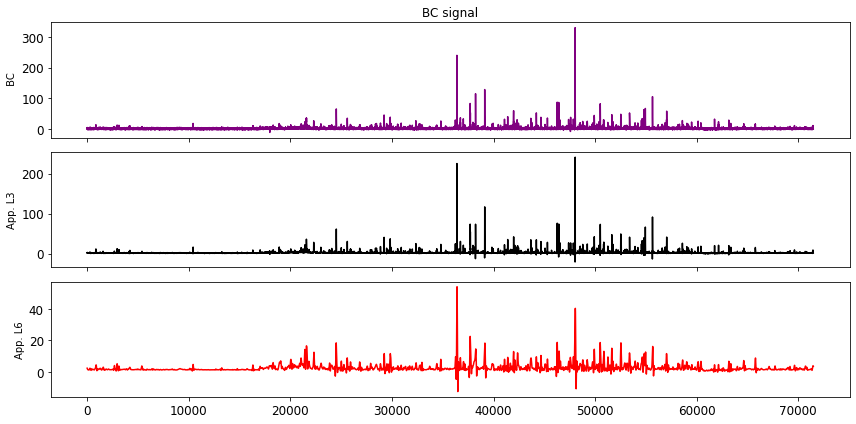

In [42]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, 
                    sharex=True, figsize=(12, 6))
# Add x-axis and y-axis
ax1.plot(df.index.values,
         df['IR BC1_ug'],
         color='purple')
# ax2.plot(app2.index.values,
#        app2['Approx_2'],
#        color='orange')

ax2.plot(app3.index.values,
         app3['Approx_3'],
         color='black')
ax3.plot(app6.index.values,
         app6['Approx_6'],
         color='red')

ax1.set(
    ylabel=" BC",
    title="BC signal")
# ax2.set(ylabel=" App. L2")
ax2.set(ylabel="App. L3")
ax3.set(ylabel="App. L6")

plt.tight_layout()
plt.savefig('./Results2/BC_ug_denoised_signal_comparison.png')
plt.show()

### (1) Reconstruct the approximations

In [43]:
A5 = A6 + D6 
A4 = A6 + D6 + D5
A3 = A6 + D6 + D5 + D4
A2 = A6 + D6 + D5 + D4 + D3
A1 = A6 + D6 + D5 + D4 + D3 + D2

### (2) Check errors

In [44]:
err = sum(s-A6)/len(s)
print(err)

0.0004225675393591947


### (3) Peak Identification

In [45]:
import matplotlib.pyplot as plt
# from scipy.misc import electrocardiogram
from scipy.signal import find_peaks

In [46]:
app6= pd.DataFrame(A6,columns=['Approx_6'] )
app6
arr6 = app6.to_numpy()
arr6

array([[2.31569126],
       [2.30568238],
       [2.29502186],
       ...,
       [3.60973318],
       [3.59315255],
       [3.57524002]])

In [47]:
array_s= recon_s6_t.to_numpy()
print(array_s)
print(len(array_s))
print(len(recon_s6_t))
print(recon_s6_t.dtypes)

[[2.315691264535336 '00:00:01.856921']
 [2.305682381232425 '00:00:02.836060']
 [2.2950218617317564 '00:00:03.854123']
 ...
 [3.60973317912526 '23:59:58.555425']
 [3.593152553042787 '23:59:59.555325']
 [3.5752400248309466 '00:00:00.555224']]
71476
71476
Approx_6    float64
time2        object
dtype: object


In [48]:
# CO2 diurnal variations 380-500 ppm in arizona and traffic
# Check Scipy package to extract features of peaks
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html

In [49]:
# to find data type in numpy arrea
A6.dtype
# to find data type in dataframe
app3.dtypes
array_s.dtype

dtype('O')

In [50]:
# fig, ax = plt.subplots(figsize=(10, 6))
# x = arr3
# x1=x.flatten()


# peaks, _ = find_peaks(x1, height=10)
# plt.plot(x)
# plt.plot(peaks, array_s[peaks], "x", color = 'red')
# # plt.axhline(350, linestyle='--',color="gray" )
# ax.set(xlabel= "Time",
#     ylabel=" BC (ug/g)",
#     title="BC peak identification after removing instrumental noise")
# plt.show()

In [51]:
# A5s1=A3[1000:3060]
# A5s1.shape
# x1_array = np.arange(1000,3060)
# # amp1 = 3000
# # sigma1 = 10
# # cen1 = 50
# y1_array= A5s1
# plt.plot(x1_array, y1_array)

In [71]:
x6_array = peak_date6
# amp1 = 3000
# sigma1 = 10
# cen1 = 50
y6_array= peak_sig6

In [53]:
# import math

# def computeTicks (x, step = 5):
#     """
#     Computes domain with given step encompassing series x
#     @ params
#     x    - Required - A list-like object of integers or floats
#     step - Optional - Tick frequency
#     """
#     xMax, xMin = math.ceil(max(x)), math.floor(min(x))
#     dMax, dMin = xMax + abs((xMax % step) - step) + (step if (xMax % step != 0) else 0), xMin - abs((xMin % step))
#     return range(dMin, dMax, step)

C:\Users\bina_\Miniconda3\envs\earth-analytics-python\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  # This is added back by InteractiveShellApp.init_path()


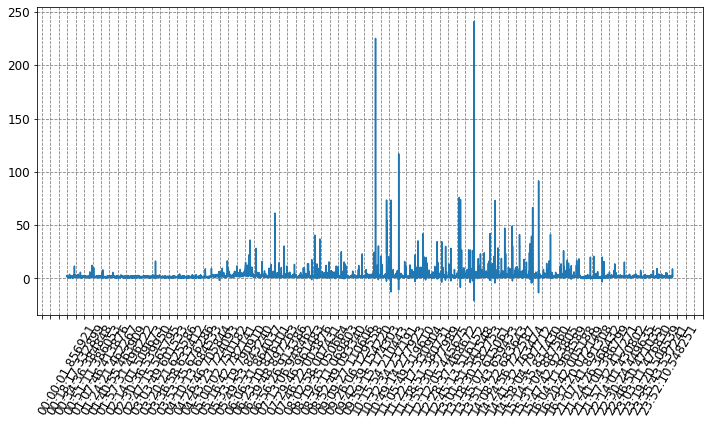

In [63]:
# A3s1=A3[1000:3060]
# A3s1.shape
# x_array = peak_date2
# # amp1 = 3000
# # sigma1 = 10
# # cen1 = 50
# y_array= peak_sig
plt.plot(s3_xarr, s3_yarr)
# plt.plot(x_array, y_array)
plt.xticks(rotation =60) # Rotates X-Axis Ticks by 45-degrees
plt.grid(b=True, which='major', color='grey', linestyle='--')
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1000))
plt.tight_layout()
#plt.savefig('./Results2/BC_denoised_S6_full.png')
plt.savefig('./Results2/BC_denoised_S3_full.png')
plt.show()

3655


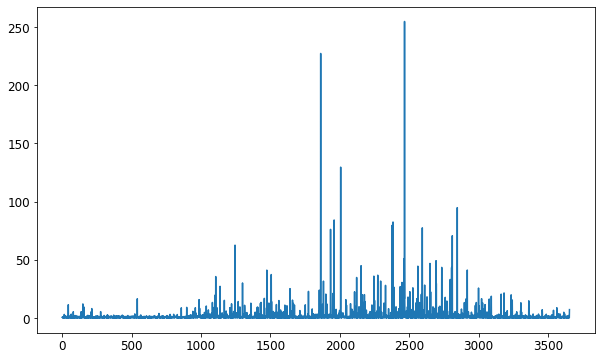

In [64]:
peaks, properties = find_peaks(s3_yarr, prominence=2, width=20)
sig_peaks, _ = signal.find_peaks(s3_yarr)
promin = signal.peak_prominences(s3_yarr, sig_peaks)[0]
print(len(promin))
# promin
plt.plot(promin)

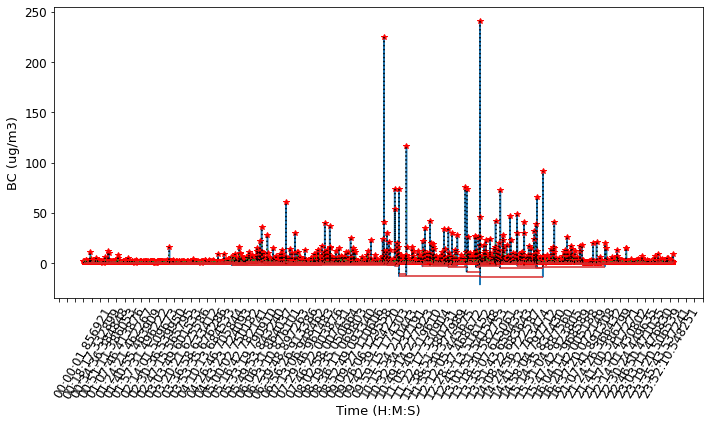

In [66]:
half_peak_res = signal.peak_widths(s3_yarr, sig_peaks, rel_height = 0.5)
full_peak_res = signal.peak_widths(s3_yarr, sig_peaks, rel_height = 1)


plt.plot(s3_xarr, s3_yarr)
plt.plot(sig_peaks, s3_yarr[sig_peaks], "*", color = 'red')
contur_height = s3_yarr[sig_peaks] - promin
# plt.plot(y_array)
# plt.plot(sig_peaks, y_array[sig_peaks], "*")
plt.vlines(x=sig_peaks, ymin=contur_height, ymax=s3_yarr[sig_peaks], 
           color ='black', linestyle='dotted')
plt.hlines(*half_peak_res[1:], color = 'C12')
plt.hlines(*full_peak_res[1:], color = 'C3')
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1000))
plt.xticks(rotation =60)
plt.ylabel('BC (ug/m3)', fontsize= 13)
plt.xlabel('Time (H:M:S)', fontsize = 13)
plt.tight_layout()
plt.savefig('./results/BC_s3_peak_area_time.png', dpi=300)
plt.show()

In [67]:
# print('Half width of peaks:', half_peak_res[0])
HWpeak = np.asarray(half_peak_res)
HWpeak_BC = pd.DataFrame(HWpeak)
# print(HWpeak_BC.head(3))
HWpeak_BC.to_csv('./results/s3_BC_HWpeak.csv')

# print('Full width of peaks:', full_peak_res[0])
FWpeak = np.asarray(full_peak_res)
FWpeak_BC = pd.DataFrame(FWpeak)
FWpeak_BC.to_csv('./results/s3_BC_FWpeak.csv')
print('Height of peaks:',contur_height)
contur_height_BC = pd.DataFrame(contur_height)
contur_height_BC.to_csv('./results/s3_BC_peak_height.csv')
# contur_height.to_csv('./results/BC_peaklength.csv')
print(len(contur_height))
print(len(half_peak_res[0]))
print(type(half_peak_res))
print(type(full_peak_res))
print(type(HWpeak))
print(type(FWpeak))
print(type(contur_height))

Height of peaks: [2.17216081 1.96730604 1.53757952 ... 1.18428162 1.53904674 1.76935346]
3655
3655
<class 'tuple'>
<class 'tuple'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [69]:
# # A6sf=A6
# # A6sf.shape
# x6_array = peak_date2
# # # # amp1 = 3000
# # # # sigma1 = 10
# # # # cen1 = 50
# y6_array= peak_sig2
# # plt.plot(x1_array, y1_array)

556


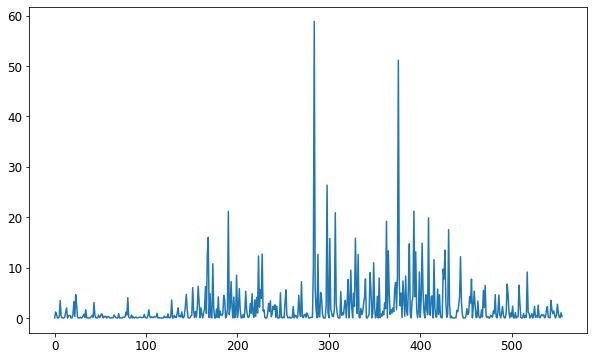

In [72]:
peaks, properties = find_peaks(y6_array, prominence=10, width=30)
sig_peaks, _ = signal.find_peaks(y6_array)
promin = signal.peak_prominences(y6_array, sig_peaks)[0]
print(len(promin))
# promin
plt.plot(promin)

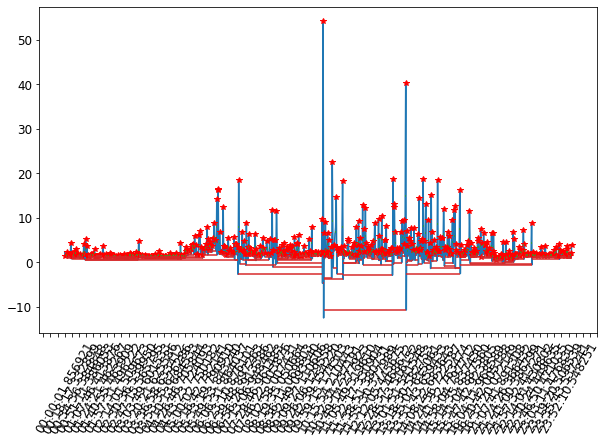

In [74]:
half_peak_res = signal.peak_widths(y6_array, sig_peaks, rel_height = 0.5)
full_peak_res = signal.peak_widths(y6_array, sig_peaks, rel_height = 1)


plt.plot(x6_array, y6_array)
plt.plot(sig_peaks, y6_array[sig_peaks], "*", color = 'red')
contur_height = y6_array[sig_peaks] - promin
# plt.plot(y_array)
# plt.plot(sig_peaks, y_array[sig_peaks], "*")
#plt.vlines(x=sig_peaks, ymin=contur_height*10, ymax=y_array[sig_peaks], 
#           color ='black', linestyle='dotted')
plt.hlines(*half_peak_res[1:], color = 'C12')
plt.hlines(*full_peak_res[1:], color = 'C3')
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1000))
plt.xticks(rotation =60)
plt.savefig('./results/s6_full_BC_peak_area_height.png')
plt.show()

In [77]:
# print('Half width of peaks:', half_peak_res[0])
HWpeak = np.asarray(half_peak_res)
HWpeak_BC = pd.DataFrame(HWpeak)
# print(HWpeak_BC.head(3))
HWpeak_BC.to_csv('./Results2/s6_full_BC_HWpeak.csv')

# print('Full width of peaks:', full_peak_res[0])
FWpeak = np.asarray(full_peak_res)
FWpeak_BC = pd.DataFrame(FWpeak)
FWpeak_BC.to_csv('./Results2/s6_full_BC_FWpeak.csv')
print('Height of peaks:',contur_height)
contur_height_BC = pd.DataFrame(contur_height)
contur_height_BC.to_csv('./Results2/s6_full_BC_peak_heigh2.csv')
# contur_height.to_csv('./results/BC_peaklength.csv')
print(len(contur_height))
print(len(half_peak_res[0]))
print(type(half_peak_res))
print(type(full_peak_res))
print(type(HWpeak))
print(type(FWpeak))
print(type(contur_height))

Height of peaks: [ 1.32441907e+00  1.08114974e+00  1.19981971e+00  1.54797373e+00
  1.54831978e+00  1.33710228e+00  9.50620828e-01  1.43272144e+00
  1.44210483e+00  1.45406081e+00  1.47311446e+00  1.95827011e+00
  1.12289419e+00  9.52058949e-01  1.51216375e+00  1.15049095e+00
  1.30085147e+00  1.32899008e+00  1.33827430e+00  1.33806864e+00
  1.14618257e+00  7.34445696e-01  1.59405824e+00  5.39824901e-01
  1.11915861e+00  1.34490072e+00  1.37141347e+00  1.35791095e+00
  1.35882812e+00  1.41721267e+00  1.56670820e+00  1.31013939e+00
  1.16619033e+00  1.63274326e+00  1.22076069e+00  1.44421726e+00
  1.30858996e+00  1.34495465e+00  1.32511564e+00  1.38793198e+00
  1.34475977e+00  1.30736445e+00  1.37568984e+00  6.62406147e-01
  1.10427049e+00  1.28812752e+00  1.28811506e+00  1.30634354e+00
  1.17644872e+00  1.37802381e+00  1.22022120e+00  1.12060296e+00
  1.15113165e+00  1.41069030e+00  1.17401329e+00  1.32268466e+00
  1.15664408e+00  1.23020742e+00  1.23406894e+00  1.29815281e+00
  1.4641